In [1]:
import xml.dom.minidom
import numpy as np
import os
import json
# from PIL import Image
from skimage import io, transform, util
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, argrelmin, argrelmax
from scipy.signal import savgol_filter
from skimage.draw import polygon
from skimage.color import rgb2gray

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

c:\users\jhelu\miniconda3\envs\cs682\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\jhelu\miniconda3\envs\cs682\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\jhelu\miniconda3\envs\cs682\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
file_list = os.listdir("datasets/prima")
ground_truth = {}
for file_name in file_list:
    if file_name[:3] == 'pc-' and file_name[-4:] == '.xml':
#         print(file_name)
        ground_truth[file_name] = {}
#         file_name = "datasets/prima/pc-00008061.xml"
        doc = xml.dom.minidom.parse("datasets/prima/"+file_name)        
        for txt_reg in doc.getElementsByTagName("TextRegion"):
            if txt_reg.getAttribute("type") == 'paragraph':# and txt_reg.getAttribute("id") in r[3:4]:# == 'r116': 

                for text in txt_reg.getElementsByTagName("TextEquiv"):
                    text_str = text.getElementsByTagName("Unicode")[0].firstChild.data
                    lines = text_str.splitlines()
                    word_list = []
                    for line in lines:
                        word_list.append(line.split(' '))
                    if len(word_list) > 2:
#                         print(txt_reg.getAttribute("type"), txt_reg.getAttribute("id"))
                        ground_truth[file_name][txt_reg.getAttribute("id")] = word_list

In [6]:
count_lines =  sum(len(ground_truth[k1][k2]) for k1 in ground_truth for k2 in ground_truth[k1] )
count_words = sum(len(word_list) for k1 in ground_truth for k2 in ground_truth[k1] for word_list in ground_truth[k1][k2])

In [11]:


def process_images(ground_truth, hor_f, hor_d, vert_f, vert_d, vert_c_p):
    images = {}
    incorrect_lines = {}
    incorrect_words = {}
    for xml_file in ground_truth:
    #     if xml_file !="pc-00008061.xml":
    #         continue
        #parse sml doc
        doc = xml.dom.minidom.parse("datasets/prima/"+xml_file)
        images[xml_file] = {}
        incorrect_lines[xml_file] = {}
        incorrect_words[xml_file] = {}
        #get image name from xml doc
        for a in doc.getElementsByTagName("Page"):
            image_name = a.getAttribute('imageFilename')

        im_full = rgb2gray(io.imread("datasets/prima/"+image_name))
#         print("image name ", image_name)
        im_full = np.asarray(im_full)
        #select regions from image with multiple lines (>2), already present in groundtruth dict
        for txt_reg in doc.getElementsByTagName("TextRegion"):
            if txt_reg.getAttribute("type") == 'paragraph' and txt_reg.getAttribute("id") in ground_truth[xml_file].keys():# == 'r116': 
    #             if txt_reg.getAttribute("id")!= 'r108':
    #                 continue
                # read bounding points of region
                x_y = []
                for coords in txt_reg.getElementsByTagName("Coords"):
                    for point in coords.getElementsByTagName("Point"):
                        x_y.append([point.getAttribute("x"), point.getAttribute("y")])
                x_y = np.asarray(x_y).astype(int)
                #create mask to crop out layer
                mask = np.zeros((max(x_y[:,1])-min(x_y[:,1]), max(x_y[:,0])-min(x_y[:,0])), dtype=np.uint8)
                rr, cc = polygon(x_y[:,1] - min(x_y[:,1]), x_y[:,0] - min(x_y[:,0]))
                mask[rr, cc] = 1
    #             plt.figure()
    #             plt.imshow(mask, cmap='gray')
                #crop region based on min-max of bounding points
                im = im_full[ min(x_y[:,1]): max(x_y[:,1]), min(x_y[:,0]):max(x_y[:,0])] 
                im = util.invert(im) * mask
                im = util.invert(im)
                #get horizontal proj. to segment line
                hor_proj = np.sum(util.invert(im), axis=1)
                hor_proj_smooth = savgol_filter(hor_proj, hor_f, hor_d)
    #             print(min(hor_proj), max(hor_proj))
    #             plt.figure(figsize=(30,5))
    #             plt.plot(np.arange(max(x_y[:,1])-min(x_y[:,1])), hor_proj)
    #             plt.plot(np.arange(max(x_y[:,1])-min(x_y[:,1])), hor_proj_smooth, c='r')
    #             plt.show()
                #get local minima from the smoothened hor. proj. 
                index_maxima = argrelextrema(hor_proj_smooth, np.greater)[0]
                index_minima = argrelextrema(hor_proj_smooth, np.less)[0]

#                 plt.figure()
#                 plt.imshow(im, cmap='gray')
#                 plt.scatter(x = x_y[:,0]-min(x_y[:,0]), y = x_y[:,1] - min(x_y[:,1]))
#                 for ind in index_minima:
#                     plt.scatter(x = 0, y=ind, c='r')
#                 plt.show()
                image_list = []
                line_number = 0
                for i in range(1, len(index_minima)):
                    image_line = []
                    #crop out each line
                    img_crop = im[index_minima[i-1]:index_minima[i], : ]
                    if np.sum(img_crop) <= 10 or np.sum(util.invert(img_crop)) <= 10:
                        continue
#                     plt.figure()
#                     plt.imshow(img_crop, cmap='gray')
#                     plt.show()
                    #get vert. proj. to segment words
                    vert_proj = np.sum(util.invert(img_crop), axis=0)
                    vert_proj_smooth = savgol_filter(vert_proj, vert_f, vert_d)
    #                 plt.figure(figsize=(30,5))
    #                 plt.plot(np.arange(vert_proj.shape[0]), vert_proj)
    #                 plt.plot(np.arange(vert_proj.shape[0]), vert_proj_smooth, c='r')
    #                 plt.show()
                    index_min = argrelextrema(vert_proj_smooth, np.less)[0]
        #             print(len(np.where(vert_proj_smooth<=0)[0]), len(index_min))
                    #get sets of consecutive inidces where vert_proj[index] == 0, represents spaces
                    spaces = consecutive(np.where(vert_proj_smooth<=0)[0], vert_c_p)
    #                 fig, axes = plt.subplots(1, len(spaces)-1, figsize=(30, 2))
    #                 for _i, ax in enumerate(axes.flat): # ax in range(1,len(spaces)):
                    for _i in range(len(spaces)-1):
                        #crop out a word
                        word = img_crop[:, spaces[_i][int(len(spaces[_i])/2)]: spaces[_i+1][int(len(spaces[_i+1])/2)]]
                        if np.sum(util.invert(word)) <=5 or np.sum(word) <= 5:
                            continue
    #                     ax.imshow(word, cmap='gray')
                        image_line.append(word)
                    image_list.append(image_line)
                    try:
                        if len(ground_truth[xml_file][txt_reg.getAttribute("id")][line_number]) != len(image_line):
#                             print("incorrect no of words ", xml_file, txt_reg.getAttribute("id"))
                            if txt_reg.getAttribute("id") not in incorrect_words[xml_file]:
                                incorrect_words[xml_file][txt_reg.getAttribute("id")] = 1
                            else:
                                incorrect_words[xml_file][txt_reg.getAttribute("id")] += 1
                        line_number += 1
                    except IndexError:
                        pass
                        #print("incorrect number of lines", xml_file, txt_reg.getAttribute("id"), len(ground_truth[xml_file][txt_reg.getAttribute("id")]))
                images[xml_file][txt_reg.getAttribute("id")] = image_list
                if len(ground_truth[xml_file][txt_reg.getAttribute("id")]) != len(image_list):
                    if txt_reg.getAttribute("id") not in incorrect_lines[xml_file]:
                        incorrect_lines[xml_file][txt_reg.getAttribute("id")] = 1
                    else:
                        incorrect_lines[xml_file][txt_reg.getAttribute("id")] += 1
                        
    return images, incorrect_lines, incorrect_words

In [ ]:
#incorrect words and lines
hor_filter_size = [11, 21, 31]
hor_function_degree = [1, 2]
vert_filter_size = [11, 21, 25, 31, 41]
vert_function_degree = [2, 3, 4]
vert_consecutive_pixels = [3, 5, 7, 9, 10]

incorrect_lines = np.zeros((4,2,7,3,5))
incorrect_words = np.zeros((4,2,7,3,5))
for h1 in range(len(hor_filter_size)):
    for h2 in range(len(hor_function_degree)):
        for v1 in range(len(vert_filter_size)):
            for v2 in range(len(vert_function_degree)):
                for v3 in range(len(vert_consecutive_pixels)):
                    print(h1, h2, v1, v2, v3)
                    _, e1, e2  = process_images(ground_truth, hor_filter_size[h1], hor_function_degree[h2],
                                                vert_filter_size[v1], vert_function_degree[v2], vert_consecutive_pixels[v3])
                    incorrect_lines[h1, h2, v1, v2, v3] = sum(e1[k1][k2] for k1 in e1 for k2 in e1[k1] )
                    incorrect_words[h1, h2, v1, v2, v3] = sum(e2[k1][k2] for k1 in e2 for k2 in e2[k1] )
                    print(sum(e1[k1][k2] for k1 in e1 for k2 in e1[k1] )/ count_lines *100)
                    print(sum(e2[k1][k2] for k1 in e2 for k2 in e2[k1] )/ count_words *100)

0 0 0 0 0


c:\users\jhelu\miniconda3\envs\cs682\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


10.489013257488876
10.537328663070335
0 0 0 0 1
10.489013257488876
10.537042026634257
0 0 0 0 2
10.489013257488876
10.537328663070335
0 0 0 0 3
10.489013257488876
10.536755390198179
0 0 0 0 4
10.489013257488876
10.535035571581718
0 0 0 1 0
10.489013257488876
10.524716659882937
0 0 0 1 1
10.489013257488876
10.52557656919117
0 0 0 1 2
10.489013257488876
10.524143387010783
0 0 0 1 3
10.489013257488876
10.524716659882937
0 0 0 1 4
10.489013257488876
10.52328347770255
0 0 0 2 0
10.489013257488876
10.582330583534457
0 0 0 2 1
10.489013257488876
10.582330583534457
0 0 0 2 2
10.489013257488876
10.581757310662303
0 0 0 2 3
10.489013257488876
10.580610764917992
0 0 0 2 4
10.489013257488876
10.579177582737607
0 0 1 0 0
10.489013257488876
10.428406817360996
0 0 1 0 1
10.489013257488876
10.428406817360996
0 0 1 0 2
10.489013257488876
10.42812018092492
0 0 1 0 3
10.489013257488876
10.42812018092492
0 0 1 0 4
10.489013257488876
10.428693453797074
0 0 1 1 0
10.489013257488876
10.408915539707746
0 0 1 

In [9]:
grad = np.gradient(hor_proj_smooth)
hor_proj_sort = sorted(hor_proj)
for i in range(1,len(grad)-1):
    if grad[i-1]<=0 and grad[i] ==0 and grad[i+1]>0 and hor_proj[i]< hor_proj_sort[int(0.2*len(hor_proj))]:
        print("minima ", i, hor_proj[i])
    elif grad[i] ==0 and grad[i+1]<0 and hor_proj[i]> hor_proj_sort[-int(0.2*len(hor_proj))]:
        print("maxima", i, hor_proj[i])
grad_2 = np.gradient(grad)/max(x_y[:,1])
#print(argrelextrema(grad_2, np.greater)[0])

NameError: name 'hor_proj_smooth' is not defined

7
11
11
14
11
10
10
1


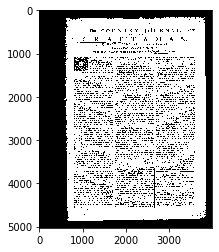

In [175]:
print(len(ground_truth['pc-00008061.xml']['r112']))
for item in ground_truth['pc-00008061.xml']['r112']:
    print(len(item))
image = io.imread('datasets/prima/00008061.tif')
plt.figure()
plt.imshow(image, cmap='gray')

In [ ]:
images[]